# 🥤Disposable Cups Classification Using YOLOv5

<center><img src="https://media4.giphy.com/media/MBmFnFVkrSTXGfVJhW/200w.webp?cid=ecf05e47u8odp6w8ixe4fkm9ppb5bq94mh7peq07rsao5gc3&rid=200w.webp&ct=s" heigth=100px width=150px></center>

## 🔬Disposable Images Classification Overview
A disposable cup is a type of tableware and disposable food packaging. Disposable cup types include paper cups, plastic cups and foam cups. Expanded polystyrene is used to manufacture foam cups, and polypropylene is used to manufacture plastic cups. As they are produced for single use, disposable cups and other similar disposable products constitute a major source of consumer and household waste, such as paper waste and plastic waste. It has been estimated that the average household discards around 70 disposable cups every year. 108 billion cups are consumed in the US per year, and the UK uses an estimated 2.5 billion paper cups every year. Source [Wikipedia](https://en.wikipedia.org/wiki/Disposable_cup).

## 🚀YOLOv5 Overview
YOLOv5 🚀 is a family of compound-scaled object detection models trained on the COCO dataset, and includes simple functionality for Test Time Augmentation (TTA), model ensembling, hyperparameter evolution, and export to ONNX, CoreML and TFLite. [Source](https://pytorch.org/hub/ultralytics_yolov5/#:~:text=YOLOv5%20%F0%9F%9A%80%20is%20a%20family,to%20ONNX%2C%20CoreML%20and%20TFLite.).


## 🙏Attribution:
The following were the external resources used in producing this notebook:
* [Convert COCO JSON format to YOLO TXT format](https://github.com/pylabel-project/samples)
* [Training YOLOv5 with Custom Dataset](https://blog.paperspace.com/train-yolov5-custom-data/)

## 💡Inspiration:
I personally don't like cups that much, but I figured that it would be a great personal project to make a image classification algorithm using algorithm about such creatures.

## ❗Author's Note:
Make sure to run the cells from top to bottom with a `GPU accelerator`. There are some linux commands present in some cells so this is important to take into account. Also, any suggestions, comments and recommendations to improve the notebook will be highly appreciated. Cheers!

# 📂Cloning YOLOv5 GitHub Files

First and foremost, we are going to retrieve the GitHub repository files that we will be using for training our own custom pharmaceutical drug images dataset. We will also be installing some of the neccessary python libraries that we will be needing later on.

In [1]:
# Cloning YOLO github
!git clone https://github.com/ultralytics/yolov5
!pip install -r yolov5/requirements.txt
!pip install utils
!pip install pylabel > /dev/null

Cloning into 'yolov5'...
remote: Enumerating objects: 12024, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 12024 (delta 16), reused 14 (delta 4), pack-reused 11984
Receiving objects: 100% (12024/12024), 12.51 MiB | 22.39 MiB/s, done.
Resolving deltas: 100% (8258/8258), done.


# 🏗️Importing the Necessary Libraries

In [2]:
import torch
import os 
import random
import shutil
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import logging
import os 
import zipfile
import yaml
import PIL

from IPython.display import Image  # for displaying images
from sklearn.model_selection import train_test_split
from pylabel import importer
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw

logging.getLogger().setLevel(logging.CRITICAL)
random.seed(42)

# ➡️Convert COCO JSON Annotations to YOLO TXT Files
The image format present in the data file is in COCO JSON format. As of the moment, I don't have any means of automating the creation of a dataset with synthetic images to produce labels in YOLO txt format. Please bare this in mind to why are we using the COCO JSON annotations. This might be an extra step but it's completely necessary because the YOLOv5 format don't understand this kind of formatting. If this process does not make any sense to you, you could automate the conversion using sites like [Roboflow](https://app.roboflow.com/).

In [3]:
from pylabel import importer

## Import COCO Annotations 
First we will import annotations from the coco dataset, which are in coco json format. The main reason why we used coco annotations and not just directly in YOLO format is because I'm having trouble creating automation python scripts that could automatically create these txt files. It's unproductive for me to manually annotate each files and label them since I'm just doing this personal projects alone.

In [4]:
# Copy images_raw to working directory
# Note: This may take some time depending on the size of your images_raw folder
!cp -r ../input/plastic-and-paper-cups-synthetic-image-dataset/images_raw ./

In [5]:
# Copy annotations to working directory
!cp -r ../input/plastic-and-paper-cups-synthetic-image-dataset/coco_instances.json ./

In [6]:
# Copy test image to output directory
!cp -r ../input/plastic-and-paper-cups-synthetic-image-dataset/test_image.jpg ./

In [7]:
#Specify path to the coco.json file
path_to_annotations = r"./coco_instances.json"
#Specify the path to the images (if they are in a different folder than the annotations)
path_to_images = r"./images_raw"

#Import the dataset into the pylable schema 
dataset = importer.ImportCoco(path_to_annotations, path_to_images=path_to_images, name="BCCD_coco")
dataset.df.head(5)

img_folder  img_filename img_path  img_id  img_width  img_height  \
id                                                                       
0   ./images_raw  00000000.jpg                0        300         300   
1   ./images_raw  00000000.jpg                0        300         300   
2   ./images_raw  00000001.jpg                1        300         300   
3   ./images_raw  00000002.jpg                2        300         300   
4   ./images_raw  00000002.jpg                2        300         300   

   img_depth ann_segmented  ann_bbox_xmin  ann_bbox_ymin  ...  \
id                                                        ...   
0                                    24.5           27.5  ...   
1                                    66.5          178.5  ...   
2                                    41.5           65.5  ...   
3                                    30.5           79.5  ...   
4                                    40.5          115.5  ...   

                                     ann_segmentation  ann_iscrowd  ann_pose  \
id                                                                             
0   [[120.0, 193.5, 92.0, 192.5, 72.0, 184.5, 57.0...            0             
1   [[113.0, 269.5, 93.0, 268.5, 85.5, 261.0, 81.5...            0             
2   [[145.0, 173.5, 133.0, 169.5, 128.0, 169.5, 61...            0             
3   [[67.0, 185.5, 48.0, 183.5, 36.5, 167.0, 36.5,...            0             
4   [[190.0, 172.5, 187.5, 164.0, 186.5, 146.0, 18...            0             

    ann_truncated  ann_difficult cat_id  cat_name cat_supercategory split  \
id                                                                          
0                                     1      cups              cups         
1                                     1      cups              cups         
2                                     1      cups              cups         
3                                     1      cups              cups         
4                                     1      cups              cups         

   annotated  
id            
0          1  
1          1  
2          1  
3          1  
4          1  

[5 rows x 25 columns]

## Analyze annotations
Pylabel can calculate basic summary statisticts about the dataset such as the number of files and the classes. 
The dataset is stored as a pandas frame so the developer can do additional exploratory analysis on the dataset. 

In [8]:
print(f"Number of images: {dataset.analyze.num_images}")
print(f"Number of classes: {dataset.analyze.num_classes}")
print(f"Classes:{dataset.analyze.classes}")
print(f"Class counts:\n{dataset.analyze.class_counts}")
print(f"Path to annotations:\n{dataset.path_to_annotations}")


Number of images: 15000
Number of classes: 1
Classes:['cups']
Class counts:
cups    29847
Name: cat_name, dtype: int64
Path to annotations:
.


## Visualize Annotations 
You can render the bounding boxes for your image to inspect them and confirm that they imported correctly.  

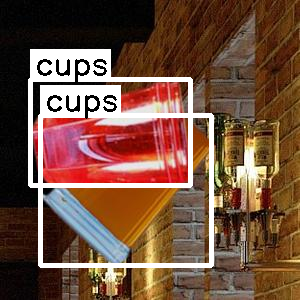

In [9]:
try:
    display(dataset.visualize.ShowBoundingBoxes(2))
    display(dataset.visualize.ShowBoundingBoxes("./images_raw/00000002.jpg"))
except:
    pass

## Export to YOLOv5 Format
The PyLabel exporter will export all of the annotations in the dataframe to the desired target format.
Yolo creates one text file for each image in the dataset. Looking at the directory file, you will now see a folder named `yolo` which contains the extracted label from the COCO JSON format as well as a `dataset.yaml` file. 

In [10]:
# This cell may take some time depending on the size of the dataset.
dataset.path_to_annotations = "labels"
dataset.export.ExportToYoloV5(output_path='text_files');

After the code cell successfully ran, you may check the output folder and confirm that there is a labels folder contatining the text files of the bbox of every images.

## Adjust Annotation Labels
Usually, the script that we ran above labels each categories from 1 - number of classes. So. let's say we have 10 classes, then the labelling would be 1-10 which is wrong in terms of formatting for the yolo dataset. Therefore, we need to adjust the labelling for each txt file so that it would mach the requirements of the YoloV5 labels.

**Important Note:** Only run the next cell block once since the code intends to subtract 1 from the original label code to adjust the label range from {1-n_classes} to {0-n_classes-1}. This is important for the .yaml file to be understood by the model later on.

In [11]:
# Note!!! Only run this code once
path = './text_files' #path of labels
labels = os.listdir(path)
for x in labels:
    lines = list()
    with open(path+"/"+x, "r+") as f:
        for line in f.read().splitlines():
            split_line = line.split(" ")  # split on space character (and remove newline characters as well)
            split_line[0] = str(
              int(split_line[0]) - 1)  # update the value inside the loop. the loop used in later not needed.
            lines.append(split_line)  # add split list into list of lines

    with open(path+"/"+x, 'w') as file:  # rewrite to file
        for line in lines:
            write_me = ' '.join(line)  # Use join method to add the element together
            file.write(write_me + "\n")


# ✂️Splitting the Dataset

In this section, we will be splitting the dataset into three categories: Train, Validation, Testing Dataset. We will use the train dataset for training the model, validation to test the model during runtime, and finally the test dataset to evaluate the model.

In [12]:
# Read images and annotations
image_dir = r'./images_raw'
images = [os.path.join(image_dir, x) for x in os.listdir(image_dir)]
annotations = [os.path.join('./text_files', x) for x in os.listdir('./text_files') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [13]:
len(train_images),len(train_annotations)

(12000, 12000)

# 🗄️Format Directories

At this stage, we are going to reformat, move, and rename directories according to what is specified in the documnetation of YOLOv5. See this [link](https://blog.paperspace.com/train-yolov5-custom-data/) for more information regarding this.


In [14]:
!mkdir images
!mkdir annotations
!mkdir images/train images/val images/test annotations/train annotations/val annotations/test

In [15]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'annotations/train/')
move_files_to_folder(val_annotations, 'annotations/val/')
move_files_to_folder(test_annotations, 'annotations/test/')

In [16]:
!mv annotations labels

Move images folder inside the yolov5 directory

In [17]:
shutil.move("./images", "./yolov5")

'./yolov5/images'

Move labels folder inside the yolov5 directory

In [18]:
shutil.move("./labels", "./yolov5")

'./yolov5/labels'

# 📰Adjusting the dataset.yaml file

At this point, you may see that the file paths inside your `dataset.yaml` file may point to the wrong directories since we moved the files inside the yolov5 folder. You may want to adjust this manually by opening the yaml file and change the path, train, val, and test directories. The main adjustment that we have to do is to specify the following:

* `path`: images
* `train`: train
* `val`: val
* `test`: test

The other default paramters should stay as is. Take note that when we are calling the dataset.yaml during training, we are inside the yolov5 directory which have the above mentioned folders in the relative path.


In [19]:
# Viewing the original unprocessed yaml file

yaml_params = {}
with open(r'dataset.yaml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    yaml_file_list = yaml.load(file, Loader=yaml.FullLoader)
    yaml_params = yaml_file_list
    print(yaml_file_list)

{'names': ['cups'], 'nc': 1, 'path': '..', 'train': 'images', 'val': 'images'}


In [20]:
# Adjusting the parameters of the yaml file
yaml_params['path'] = 'images'
yaml_params['train'] = 'train'
yaml_params['val'] = 'val'
yaml_params['test'] = 'test'
yaml_params

{'names': ['cups'],
 'nc': 1,
 'path': 'images',
 'train': 'train',
 'val': 'val',
 'test': 'test'}

In [21]:
# Overwriting the new params from the previous ones.
with open(r'dataset.yaml', 'w') as file:
    documents = yaml.dump(yaml_params, file)

You should double check that the dataset.yaml file has been adjusted to fit the abovementioned requirements.

In [22]:
# Moving the dataset.yaml inside the yolov5/data folder.
shutil.move("dataset.yaml", "yolov5/data")

'yolov5/data/dataset.yaml'

In [23]:
shutil.move("./test_image.jpg", "./yolov5")

'./yolov5/test_image.jpg'

# 🤹‍♂️Training the Custom Dataset using YOLOv5

Now, we train the network. We use various flags to set options regarding training.

* **img:** Size of image. The image is a square one. The original image is resized while maintaining the aspect ratio. The longer side of the image is resized to this number. The shorter side is padded with grey color. In our case the image size would be `300px`.
* **batch:** The batch size which will be 32
* **epochs:** Number of epochs to train for. In our case, we are just hoing to train it with 20 epochs to not make it too long. You may ajdust this to your own use case.
* **data:** Data YAML file that contains information about the dataset (path of images, labels)
* **workers:** Number of CPU workers
* **cfg:** Model architecture. There are 4 choices available: yolo5s.yaml, yolov5m.yaml, yolov5l.yaml, yolov5x.yaml. The size and complexity of these models increases in the ascending order and you can choose a model which suits the complexity of your object detection task. In case you want to work with a custom architecture, you will have to define a YAML file in the models folder specifying the network architecture.
weights: Pretrained weights you want to start training from. If you want to train from scratch, use --weights ' '
* **name:** Various things about training such as train logs. Training weights would be stored in a folder named runs/train/name
* **hyp:** YAML file that describes hyperparameter choices. For examples of how to define hyperparameters, see data/hyp.scratch.yaml. If unspecified, the file data/hyp.scratch.yaml is used.

The hyperparameter config file helps us define the hyperparameters for our neural network. We are going to use the default one, data/hyp.scratch-low.yaml. See yolov5/data/hyps to check what it looks like.[Source](https://blog.paperspace.com/train-yolov5-custom-data/)

In [24]:
# Change the current directory inisde the yolov5
%cd ./yolov5

/kaggle/working/yolov5


## Training using YOLOv5

In [25]:
!python train.py --img 320 --cfg yolov5s.yaml --hyp hyp.scratch-low.yaml --batch 32 --epochs 20 --data dataset.yaml --weights yolov5s.pt --workers 24 --name yolo_cup_det

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=dataset.yaml, hyp=hyp.scratch-low.yaml, epochs=20, batch_size=32, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=runs/train, name=yolo_cup_det, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-59-g5d3d051 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentu

# ✔️Running Inferenece on the Test Data

There are many ways to run inference using the detect.py file.

The source flag defines the source of our detector, which can be:

* A single image
* A folder of images
* Video
* Webcam

...and various other formats. We want to run it over our test images so we set the source flag to .. yolov5/images/test.

The weights flag defines the path of the model which we want to run our detector with.
conf flag is the thresholding objectness confidence.
name flag defines where the detections are stored. We set this flag to yolo_road_det; therefore, the detections would be stored in runs/detect/yolo__det/.
With all options decided, let us run inference over our test dataset.

In [26]:
!python detect.py --source images/test --weights runs/train/yolo_cup_det/weights/best.pt --conf 0.25 --name yolo_cup_det

detect: weights=['runs/train/yolo_cup_det/weights/best.pt'], source=images/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_cup_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.2-59-g5d3d051 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1500 /kaggle/working/yolov5/images/test/00000005.jpg: 640x640 1 cups, 6.2ms
image 2/1500 /kaggle/working/yolov5/images/test/00000006.jpg: 640x640 1 cups, 6.3ms
image 3/1500 /kaggle/working/yolov5/images/test/00000007.jpg: 640x640 1 cups, 7.7ms
image 4/1500 /kaggle/working/yolov5/images/test/00000022.jpg: 640x640 (no detections), 6.2m

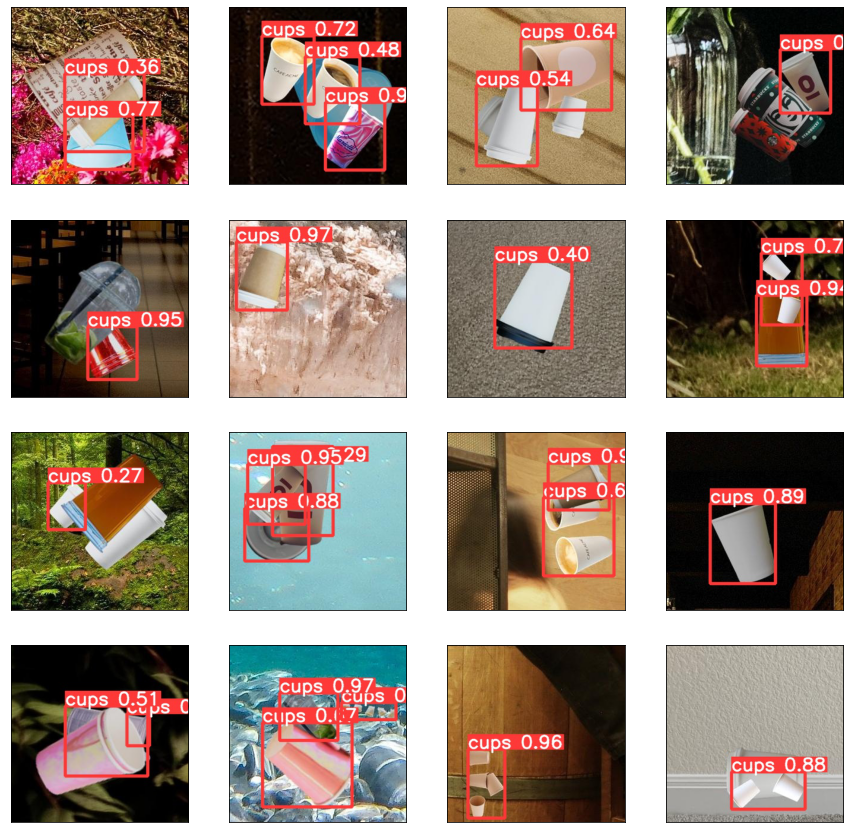

In [27]:
detections_dir = "runs/detect/yolo_cup_det/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    random_detection_image = PIL.Image.open(random.choice(detection_images))
    ax.imshow(random_detection_image)


# 🔮Predict on our own Test Image

In [28]:

!python detect.py --source ./test_image.jpg --weights runs/train/yolo_cup_det/weights/best.pt --conf 0.25 --name yolo_cup_det

detect: weights=['runs/train/yolo_cup_det/weights/best.pt'], source=./test_image.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_cup_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.2-59-g5d3d051 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /kaggle/working/yolov5/test_image.jpg: 512x640 6 cupss, 10.6ms
Speed: 0.6ms pre-process, 10.6ms inference, 1.2ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/yolo_cup_det2


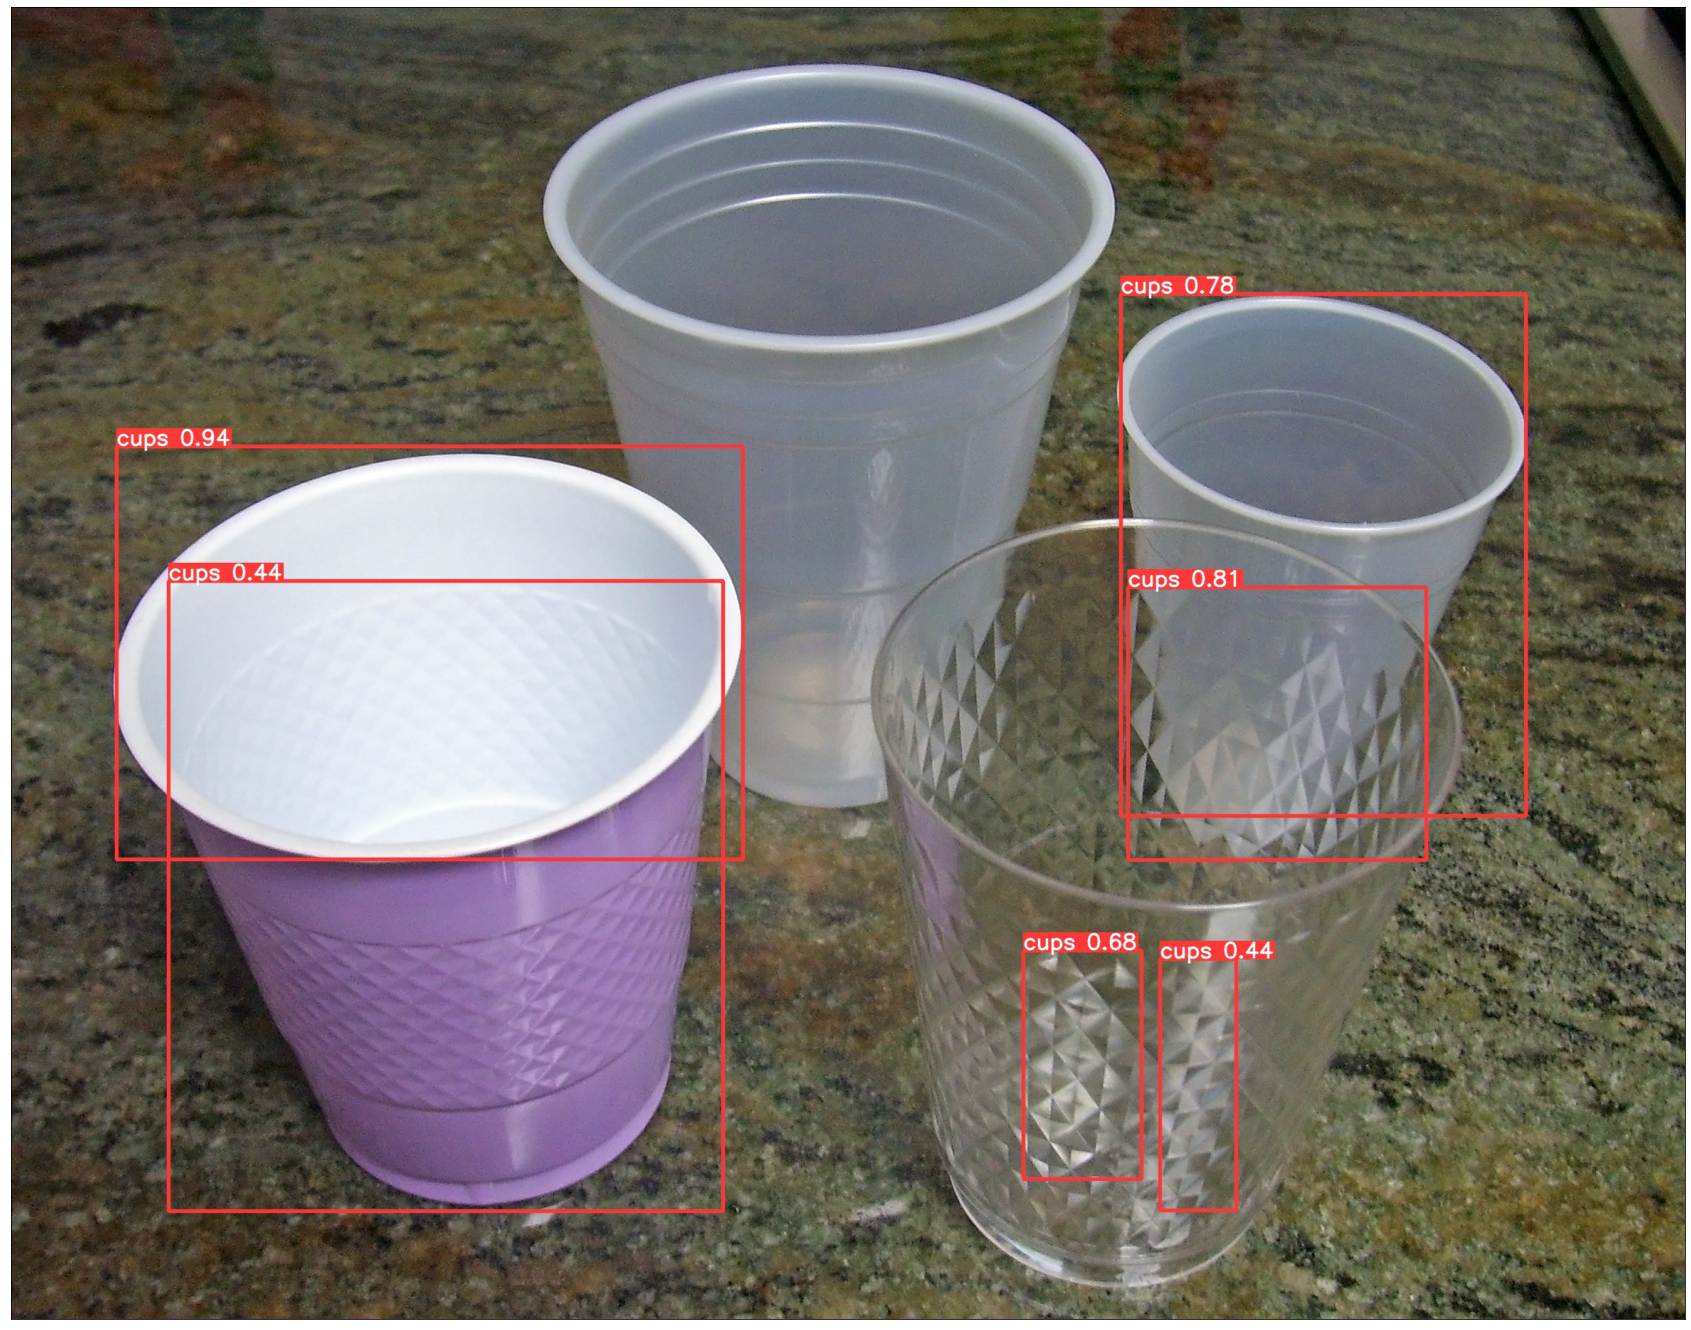

In [29]:
detections_dir = "runs/detect/yolo_cup_det2/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]
random_detection_image = PIL.Image.open(random.choice(detection_images))
plt.figure(figsize=(30,30));
plt.imshow(random_detection_image)
plt.xticks([])
plt.yticks([]);

### Thanks for viewing the notebook. I would greatly appreciate any feedback, suggestions and recommendations for improvement. Cheers! 

<center><img src='https://media4.giphy.com/media/M9gbBd9nbDrOTu1Mqx/giphy.gif?cid=790b7611704aa2ca4e403287801480a6c753abf45f3e6242&rid=giphy.gif&ct=s' 
     height=30px width=160px /></center>